In [343]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pywt

panel_data_df = pd.read_pickle('data/panel_data.pkl')
panel_data_df.set_index("index", inplace=True)
panel_data_df.index = pd.to_datetime(panel_data_df.index)
panel_data_df


,Maturity 1,Maturity 2,Maturity 3,Maturity 4,Maturity 5
index,,,,,
1988-01-04,187.5,193.5,198.25,200.0,202.75
1988-01-05,187.5,193.25,197.25,198.25,200.75
1988-01-06,191.0,195.75,199.75,201.75,204.5
1988-01-07,192.75,198.75,202.75,204.5,208.5
1988-01-08,192.5,198.0,202.0,203.5,207.25
...,...,...,...,...,...
2023-12-22,473.0,485.75,495.5,498.25,504.5
2023-12-26,480.25,492.25,501.5,503.5,509.5
2023-12-27,476.5,488.5,498.0,500.25,506.5


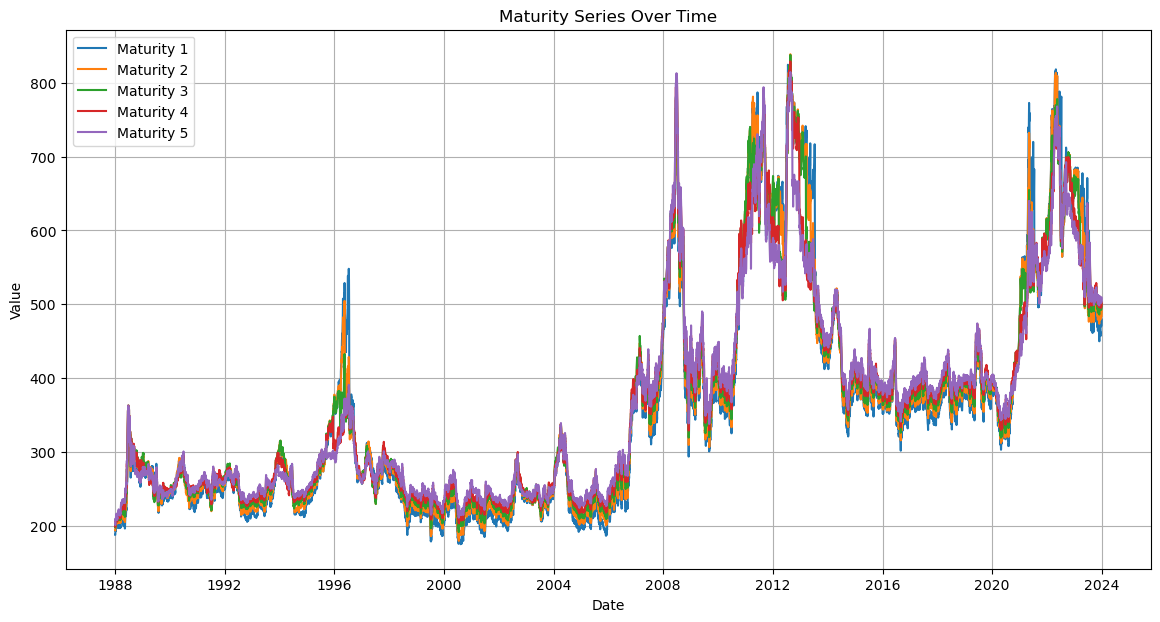

In [344]:
# Plotting the series
plt.figure(figsize=(14, 7))
for column in panel_data_df.columns:
    plt.plot(panel_data_df.index, panel_data_df[column], label=column)

plt.title('Maturity Series Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

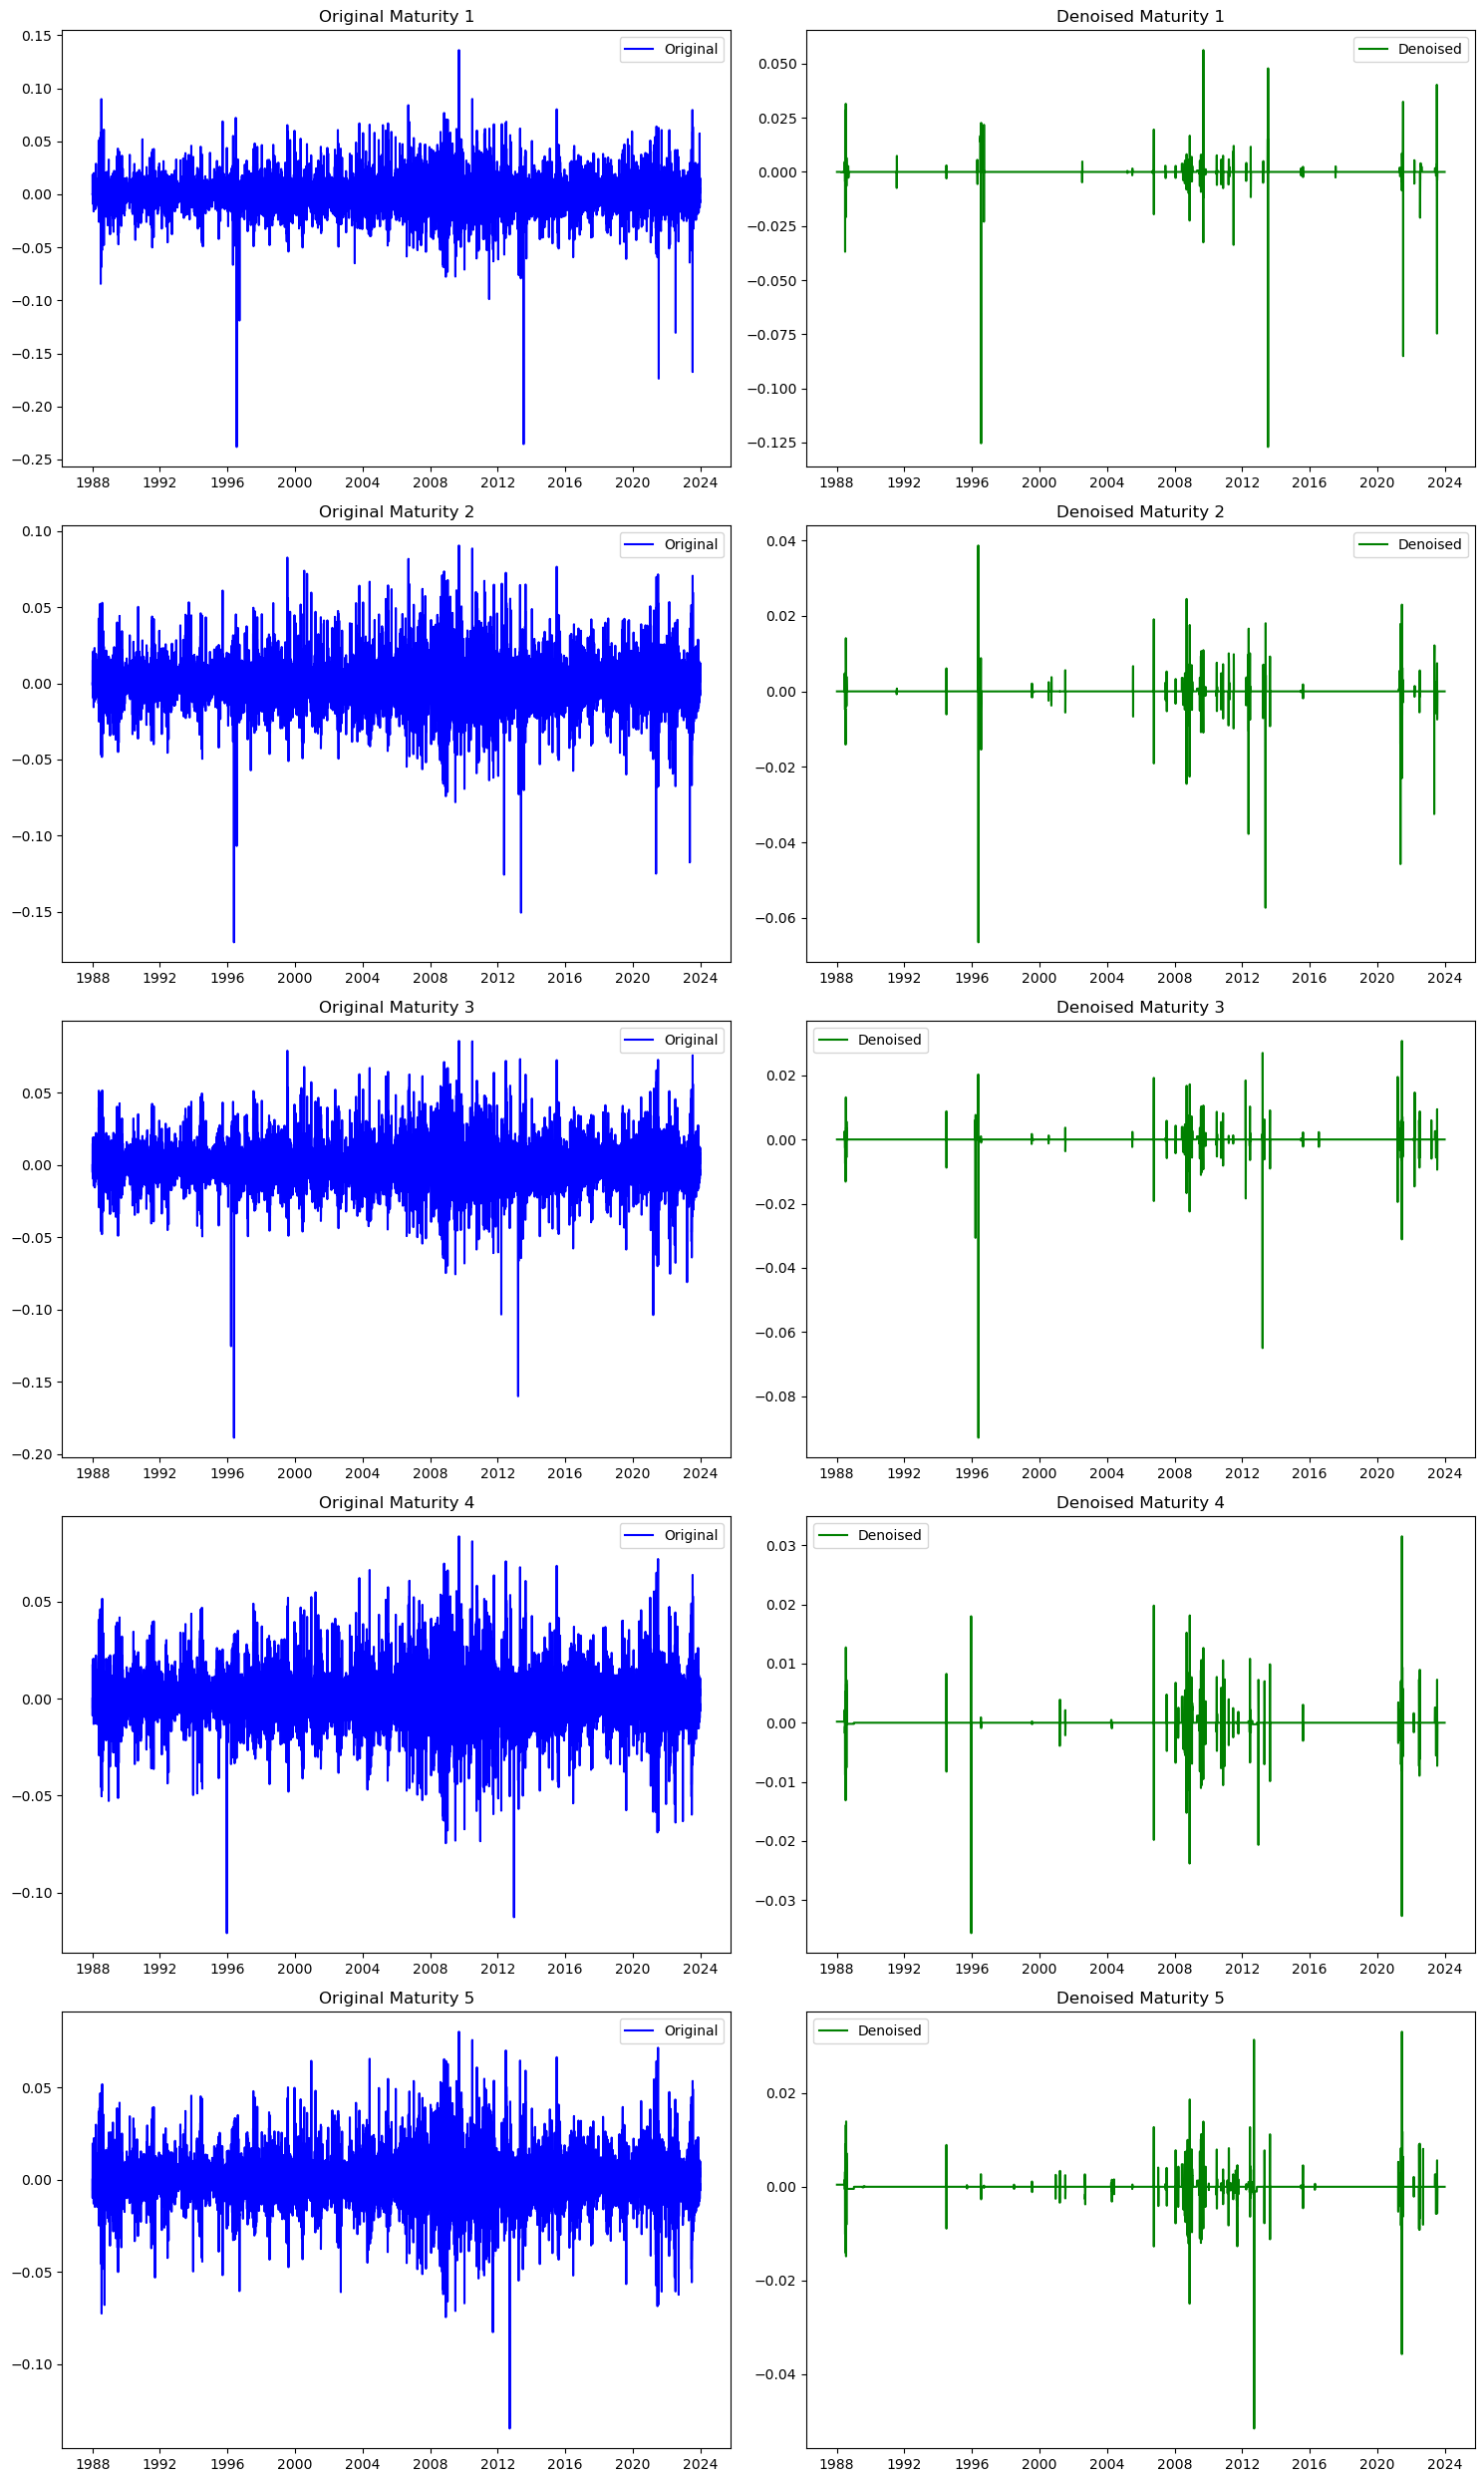

In [353]:
# Function to denoise a signal using wavelet transform
def denoise_signal(signal, wavelet='db1'):
    # Découper la transformée en ondelettes
    coeffs = pywt.wavedec(signal, wavelet)

    # Calculer le seuil universel
    #sigma = np.median(coeffs)/ 0.6745
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(signal)))
    
    # Appliquer le seuil
    coeffs_thresholded = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
    
    # Reconstruire le signal débruité
    denoised_signal = pywt.waverec(coeffs_thresholded, wavelet)

    return denoised_signal

return_df = panel_data_df.pct_change(1).fillna(0)

# Appliquer la fonction de débruitage
denoised_series = {}
for column in return_df.columns:
    signal = return_df[column].values
    denoised_signal = denoise_signal(signal, wavelet='db1')  # Ajuster le niveau si nécessaire
    denoised_series[column] = denoised_signal[:len(return_df)]  # Ajuster à la longueur originale si nécessaire

# Creating a dataframe for the denoised series
denoised_return_df = pd.DataFrame(denoised_series, index=return_df.index)

def plot_comparison(initial_df, denoised_df):

    # Déterminer le nombre de colonnes pour configurer les subplots
    num_columns = len(initial_df.columns)
    plt.figure(figsize=(15, 5 * num_columns))  # Ajuster la taille du graphique en fonction du nombre de colonnes

    for i, column in enumerate(initial_df.columns, 1):
        # Tracer la série originale
        plt.subplot(num_columns, 2, 2*i-1)
        plt.plot(initial_df.index, initial_df[column], label="Original", color='blue')
        plt.title(f"Original {column}")
        plt.legend()

        # Tracer la série débruitée
        plt.subplot(num_columns, 2, 2*i)
        plt.plot(denoised_df.index, denoised_df[column], label="Denoised", color='green')
        plt.title(f"Denoised {column}")
        plt.legend()

    plt.tight_layout()  # Ajuster automatiquement le layout
    plt.show()

plot_comparison(return_df, denoised_return_df)

In [346]:
# Utiliser les prix initiaux réels
initial_prices = panel_data_df.iloc[0]
# Calculer les prix en une seule ligne en utilisant les prix initiaux de la première journée
prices_reconstructed_df = pd.DataFrame({asset: initial_prices[asset] * (1 + denoised_return_df[asset]).cumprod() for asset in denoised_return_df.columns})

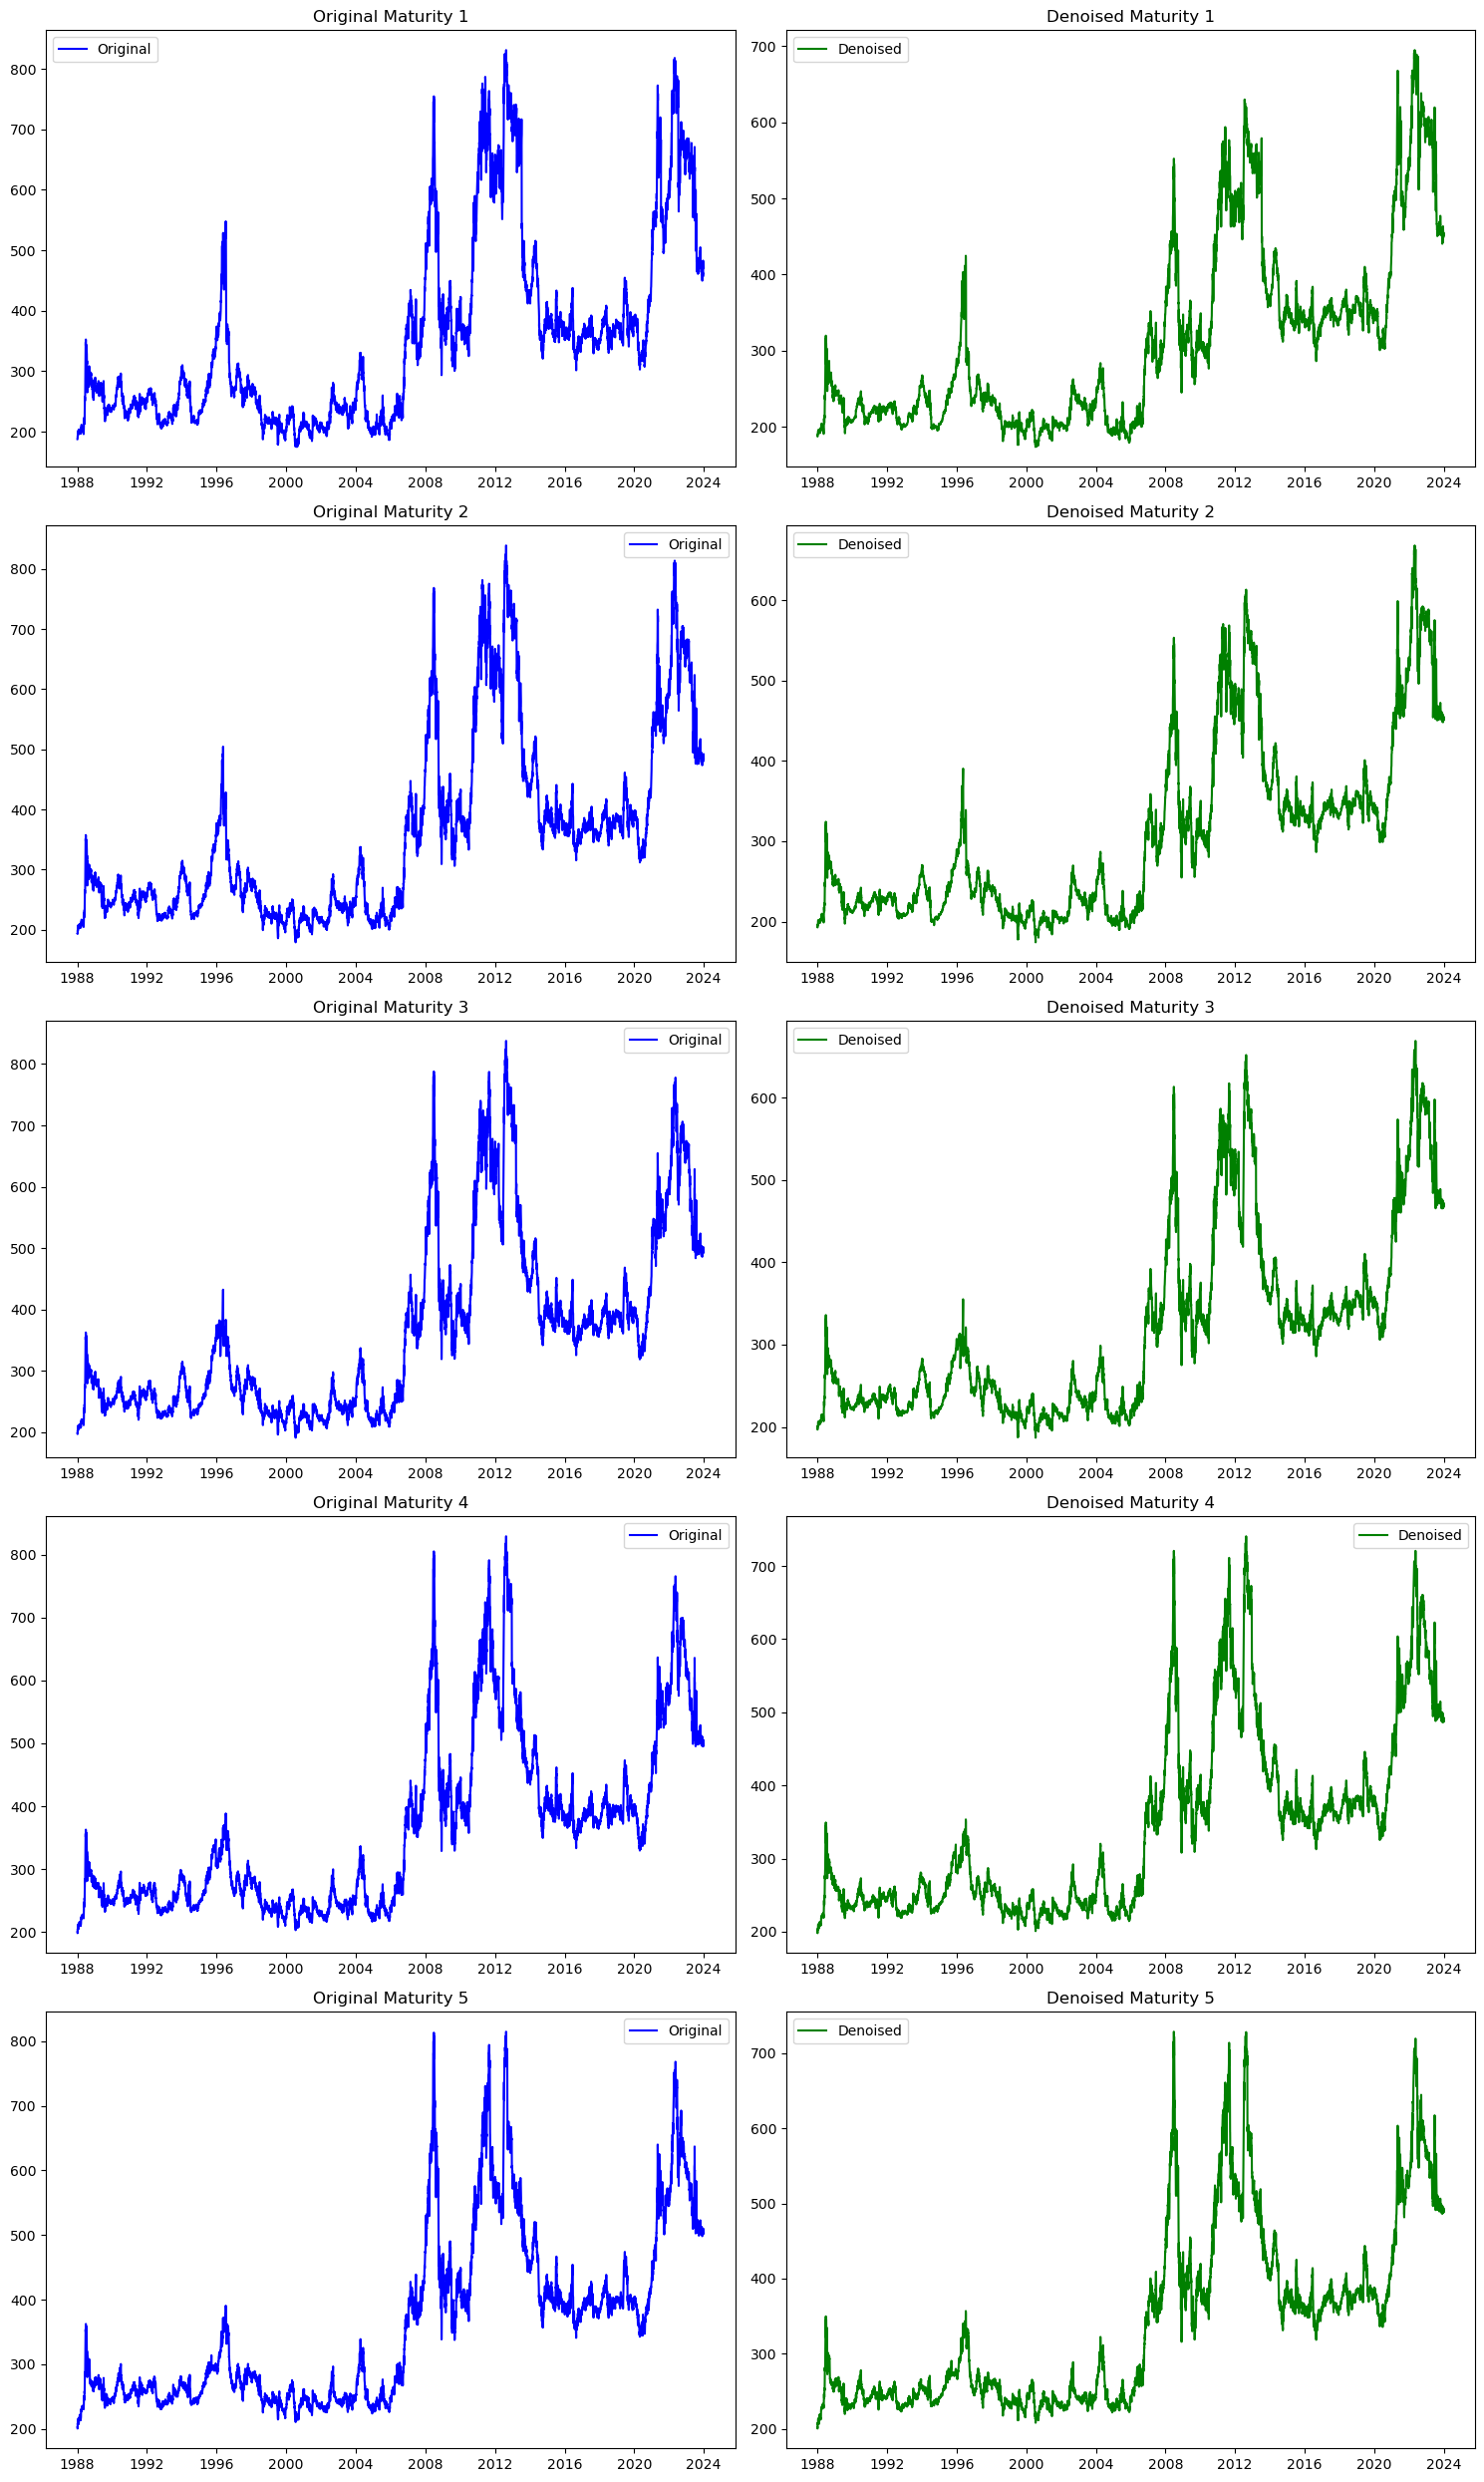

In [347]:
plot_comparison(panel_data_df, prices_reconstructed_df)

In [348]:
panel_data_df.loc["2018-01-04":"2018-01-10",:]

,Maturity 1,Maturity 2,Maturity 3,Maturity 4,Maturity 5
index,,,,,
2018-01-04,351.0,359.25,367.75,375.25,384.5
2018-01-05,351.25,359.25,367.5,375.25,384.5
2018-01-08,347.25,355.5,363.75,371.75,381.0
2018-01-09,349.0,357.25,365.5,373.5,382.5
2018-01-10,349.0,357.0,365.0,373.0,382.75


In [349]:
prices_reconstructed_df.loc["2018-01-04":"2018-01-10",:]

,Maturity 1,Maturity 2,Maturity 3,Maturity 4,Maturity 5
index,,,,,
2018-01-04,341.678922,333.566062,330.170806,356.770549,361.357899
2018-01-05,341.385628,333.281738,329.691479,356.375965,360.995772
2018-01-08,340.060924,332.029094,328.089598,354.039696,358.735044
2018-01-09,341.910850,333.492410,329.620426,355.810515,360.325395
2018-01-10,342.177474,333.600575,329.588643,355.534072,360.447020


#### Estimate coeffs of cyclical function

In [350]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Simuler des données avec moins de bruit et plus de points de données
np.random.seed(0)
t = np.linspace(1, 200, 400)  # Plus de points de données
data = {
    's_t': 3 * np.cos(2 * np.pi * t) + 2 * np.sin(2 * np.pi * t) +
           1.5 * np.cos(4 * np.pi * t) + 1 * np.sin(4 * np.pi * t) +
           np.random.normal(0, 0.25, 400)  # Moins de bruit
}
df = pd.DataFrame(data)

# Préparer les données pour la régression
df['cos_1t'] = np.cos(2 * np.pi * t)
df['sin_1t'] = np.sin(2 * np.pi * t)
df['cos_2t'] = np.cos(4 * np.pi * t)
df['sin_2t'] = np.sin(4 * np.pi * t)

# Régression linéaire
X = df[['cos_1t', 'sin_1t', 'cos_2t', 'sin_2t']]
#X = sm.add_constant(X)  # ajoute une constante
y = df['s_t']

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())


                                 OLS Regression Results                                
Dep. Variable:                    s_t   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                          1.338e+04
Date:                Fri, 03 May 2024   Prob (F-statistic):                        0.00
Time:                        21:40:11   Log-Likelihood:                         -5.9343
No. Observations:                 400   AIC:                                      19.87
Df Residuals:                     396   BIC:                                      35.83
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [351]:
t = np.array(range(1, len(return_df) + 1))
# Préparer les données pour la régression
df = pd.DataFrame({
    'cos_1t': np.cos(2 * np.pi * t/ 200),  # Assurez-vous que la périodicité est correcte
    'sin_1t': np.sin(2 * np.pi * t/ 200),
    'cos_2t': np.cos(4 * np.pi * t/ 200),
    'sin_2t': np.sin(4 * np.pi * t/ 200)
}, index=return_df.index)  # Utiliser l'index de 'return_df'

# Vérifier que les indices sont alignés
assert y.index.equals(X.index), "Les indices ne sont pas alignés!"

X = sm.add_constant(df)
y = return_df['Maturity 1']

# Exécuter la régression linéaire
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:             Maturity 1   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.343
Date:                Fri, 03 May 2024   Prob (F-statistic):              0.251
Time:                        21:40:11   Log-Likelihood:                 24100.
No. Observations:                9076   AIC:                        -4.819e+04
Df Residuals:                    9071   BIC:                        -4.815e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      1.395      0.1

In [352]:
df

,cos_1t,sin_1t,cos_2t,sin_2t
index,,,,
1988-01-04,0.999507,0.031411,9.980267e-01,0.062791
1988-01-05,0.998027,0.062791,9.921147e-01,0.125333
1988-01-06,0.995562,0.094108,9.822873e-01,0.187381
1988-01-07,0.992115,0.125333,9.685832e-01,0.248690
1988-01-08,0.987688,0.156434,9.510565e-01,0.309017
...,...,...,...,...
2023-12-22,-0.637424,0.770513,-1.873813e-01,-0.982287
2023-12-26,-0.661312,0.750111,-1.253332e-01,-0.992115
2023-12-27,-0.684547,0.728969,-6.279052e-02,-0.998027
